Notebook by Andrew Frank Schober on 11/08/19

In [46]:
%matplotlib inline
%load_ext line_profiler
import coevo2 as ce
import numpy as np
import itertools as it
import copy
import matplotlib.pyplot as plt
from multiprocessing import Pool
import random
import copy

In [2]:
#make a nice blue-white-red colormap
from matplotlib.colors import LinearSegmentedColormap
cdict = {'red':   ((0.0,  0.230, 0.230),
                   (0.5,  0.865, 0.865),
                   (1.0,  0.706, 0.706)),

        'green': ((0.0,  0.299, 0.299),
                  (0.5,  0.865, 0.865),
                  (1.0,  0.016, 0.016)),

        'blue':  ((0.0,  0.754, 0.754),
                  (0.5,  0.865, 0.865),
                  (1.0,  0.150, 0.150))}
sci_bluered = LinearSegmentedColormap('BlueRed1', cdict)

In [3]:
# String labels for half-protein nomenclature consistent with the .fastas generated by Xuexin
names = ['cydA','cydB','fliG','fliM','fliN','folA','thyA','glgA','glgC','ilvB',
        'ilvC','nrdA','nrdB','purC','purE','purK','trpA','trpB']
splitNames = []
for name in names:
    splitNames.append(name+'_half1')
    splitNames.append(name+'_half2')

In [4]:
print splitNames

['cydA_half1', 'cydA_half2', 'cydB_half1', 'cydB_half2', 'fliG_half1', 'fliG_half2', 'fliM_half1', 'fliM_half2', 'fliN_half1', 'fliN_half2', 'folA_half1', 'folA_half2', 'thyA_half1', 'thyA_half2', 'glgA_half1', 'glgA_half2', 'glgC_half1', 'glgC_half2', 'ilvB_half1', 'ilvB_half2', 'ilvC_half1', 'ilvC_half2', 'nrdA_half1', 'nrdA_half2', 'nrdB_half1', 'nrdB_half2', 'purC_half1', 'purC_half2', 'purE_half1', 'purE_half2', 'purK_half1', 'purK_half2', 'trpA_half1', 'trpA_half2', 'trpB_half1', 'trpB_half2']


In [5]:
# Load protein halves as individual "Prot" objects
algPath = 'TestSet/eggNOG_aligns/'
splitAlgPath = algPath+'split_aligns/'
prots = ce.prots_from_scratch(splitNames,path2alg=splitAlgPath)
ps = ce.ProtSet(prots,splitNames)

In [6]:
# Load full length proteins for construction of a phylogenetic model 
fl_prots = ce.prots_from_scratch(names,path2alg=algPath)
# Phylogenetic model from housekeeping genes
phylo_names = ['aspS','ffh','lepA','pgk','recN','rho','rpoA','ruvB','tig','uvrB']
phylo_prots = ce.prots_from_scratch(phylo_names,path2alg='TestSet/eggNOG_aligns/phylogenes/')

In [7]:
phylo2 = ce.PhyloSet(phylo_prots)
phylo2.set_indexer(thresh=7)
for pt in phylo2.prots:  # temporary fix for duplicated locus ids in the same msa
    pt.msa = pt.msa[~pt.msa.index.duplicated(keep='first')]
phylo2.set_sim_mat()

Keeping: 1641 species


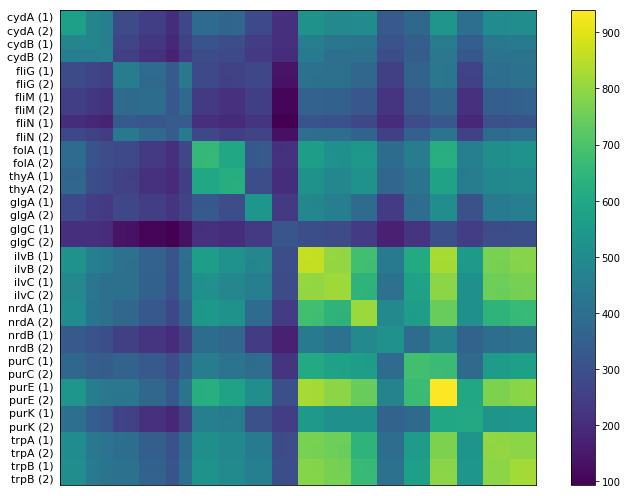

In [8]:
Nprot = len(ps.prots)
meffmat = np.zeros((Nprot,Nprot))
for pair in ps.pairs: 
    msa1, msa2, tids = pair.filter_alns(phylo2.index) # return one msa for each family and a list of taxids
    phylo_vec,specw,pwsw,Meff = phylo2.info(tids,0.1)
    meffmat[pair.ij] = specw.sum()
meffmat = ce.symmetrize(meffmat)
for j,pt in enumerate(ps.prots): 
    msa, tids = pt.filter_aln(phylo2.index)
    phylo_vec, specw, pwsw, Meff = phylo2.info(tids, 0.1)
    meffmat[j,j] = specw.sum()
    
plt.figure(figsize=(10,7))
plt.imshow(meffmat,cmap='viridis');
  
ticks = np.convolve(np.insert(range(1,Nprot+1), 0, 0), np.ones((2,))/2, mode='valid') - 0.5 
opts = {'left':'off','bottom':'off', 'top':'off', 'labelbottom':'off','labeltop':'off'}
plt.tick_params(axis='both', **opts);

label_names = [ name.split('_')[0]+' ('+name.split('_')[1][-1]+')' for name in ps.names ]
plt.yticks(ticks, label_names, size=11);

cbar = plt.colorbar();
cbar.ax.tick_params(labelsize=10);

plt.tight_layout()

In [10]:
mt_mat2 = ce.mirror_tree(ps,phylo2, 0.1)

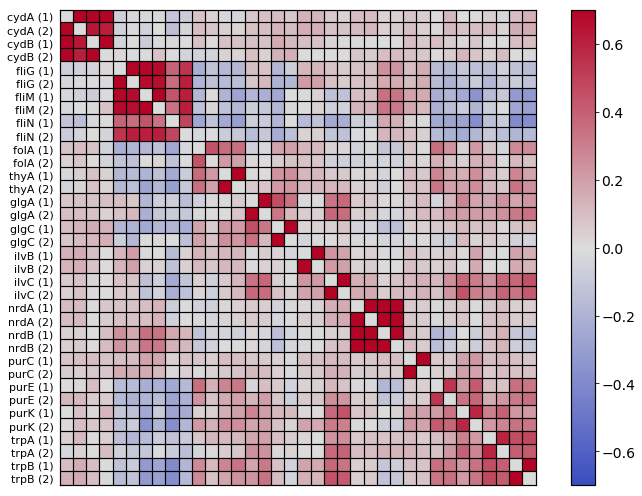

In [11]:
#plotting the results
DIVIDERWIDTH = 1.2
plt.figure(figsize=(10,7))
plt.rcParams['axes.linewidth'] = DIVIDERWIDTH # Change axes thickness

#Stuff for generative divider lines
Nprot = len(ps.prots)
span = np.array([0,Nprot]) - 0.5
ticks = np.convolve(np.insert(range(1,Nprot+1), 0, 0), np.ones((2,))/2, mode='valid') - 0.5 
divs = ticks+0.5
ones = np.ones(2)
opts = {'left':'off','bottom':'off', 'top':'off', 'labelbottom':'off','labeltop':'off'}

plt.imshow(mt_mat2,cmap=sci_bluered,vmin=-0.7,vmax=0.7);
opts = {'left':'off','bottom':'off', 'top':'off', 'labelbottom':'off','labeltop':'off'}
plt.tick_params(axis='both', **opts)

label_names = [ name.split('_')[0]+' ('+name.split('_')[1][-1]+')' for name in ps.names ]
plt.yticks(ticks, label_names, size=11);
    
# This code is adapted from my thesis and adds black divider lines
for pos in divs[:-1]:
    plt.plot(span, (pos-0.1)*ones, color='k', linewidth=DIVIDERWIDTH)
    plt.plot((pos-0.05)*ones, span, color='k', linewidth=DIVIDERWIDTH)
    
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=14);
plt.tight_layout()

In [17]:
def sca_parallel_calc(args):
    msa_num,seqw,posw = args
    return ce.scamat_calc(msa_num,seqw,posw)
    
    
# Write code for the parallel computation of SCA matrices
def sca_parallel(ps, phylo, delta=0.1, thread_lim=48):
    prot_inputs = []
    for pt in ps.prots: # should probably move these inside their own functions
        msa,tids = pt.filter_aln(phylo.index)
        phylo_vec,specw,pwsw,Meff = phylo.info(tids,delta)
        
        X2d = ce.binarize_msa(msa,Naa=21)
        simMat = (X2d.dot(X2d.T))/msa.shape[1]
        seqw = np.array(1./(simMat>(1.-delta)).sum(axis=0))
        posw = ce.posw_calc(msa,seqw)
        
        prot_inputs.append([msa,seqw,posw])
        
    pair_inputs = []
    pair_rand_inputs = []
    for pair in ps.pairs:
        msa1, msa2, tids = pair.filter_alns(phylo.index)
        phylo_vec,specw,pwsw,Meff = phylo.info(tids,delta)
        
        cat = np.concatenate([msa1,msa2],axis=1)
        X2d = ce.binarize_msa(cat,Naa=21)
        simMat = (X2d.dot(X2d.T))/cat.shape[1]
        seqw = np.array(1./(simMat>(1.-delta)).sum(axis=0))
        posw = ce.posw_calc(cat,seqw)
        
        pair_inputs.append([cat,seqw,posw])
        
        #randomization and storage of inputs
        randSample = random.sample(range(msa2.shape[0]),msa2.shape[0])
        m2shuffle= np.zeros(msa2.shape).astype(int)
        for i,randN in enumerate(randSample):
            m2shuffle[i,:] = msa2[randN,:]

        mcombRand = np.concatenate((msa1,m2shuffle),axis=1)
        X2d = ce.binarize_msa(mcombRand,Naa=21)
        simMat = (X2d.dot(X2d.T))/mcombRand.shape[1]
        seqw = np.array(1./(simMat>(1-delta)).sum(axis=0)) # new seqw for random-mat
        
        pair_rand_inputs.append([mcombRand,seqw,posw])
        
    pool = Pool(thread_lim)
    prot_results = pool.map_async(sca_parallel_calc,prot_inputs)
    pair_results = pool.map_async(sca_parallel_calc,pair_inputs)
    pair_rand_results = pool.map_async(sca_parallel_calc,pair_rand_inputs)
    protmats = prot_results.get()
    pairmats = pair_results.get()
    pairrands = pair_rand_results.get()
    pool.terminate()
    return protmats,pairmats,pairrands

In [19]:
%%time 
protmats,pairmats,pairrands = sca_parallel(ps,phylo2)

CPU times: user 41min 33s, sys: 52.6 s, total: 42min 26s
Wall time: 7min 9s


In [27]:
for pt,sca_mat in it.izip(ps.prots,protmats): pt.sca_mat = sca_mat
sca_intrxn = np.zeros((Nprot,Nprot))
for pair,sca_cat,sca_cat_rand in it.izip(ps.pairs,pairmats,pairrands): 
    Npos1 = pair.prots[0].Npos
    sca_cat = sca_cat[:Npos1,Npos1:]
    sca_cat_rand = sca_cat_rand[:Npos1,Npos1:]
    pair.sca_cat = sca_cat-sca_cat_rand
    sca_intrxn[pair.ij] = pair.sca_cat.mean()
sca_intrxn = ce.symmetrize(sca_intrxn)

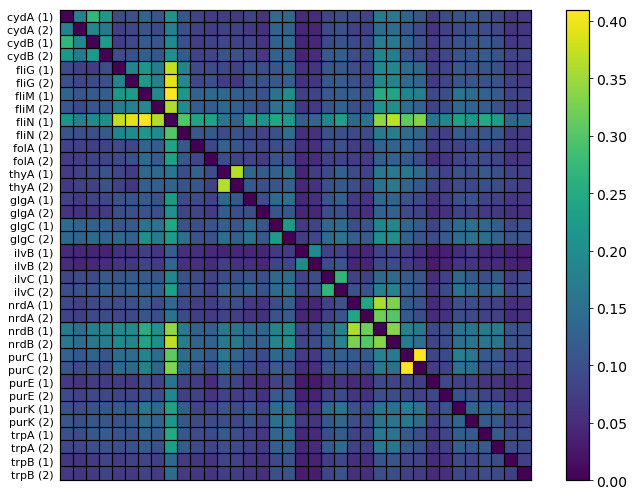

In [36]:
#plotting the results
DIVIDERWIDTH = 1.2
plt.figure(figsize=(10,7))
plt.rcParams['axes.linewidth'] = DIVIDERWIDTH # Change axes thickness

#Stuff for generative divider lines
Nprot = len(ps.prots)
span = np.array([0,Nprot]) - 0.5
ticks = np.convolve(np.insert(range(1,Nprot+1), 0, 0), np.ones((2,))/2, mode='valid') - 0.5 
divs = ticks+0.5
ones = np.ones(2)
opts = {'left':'off','bottom':'off', 'top':'off', 'labelbottom':'off','labeltop':'off'}

plt.imshow(sca_intrxn,cmap='viridis');
opts = {'left':'off','bottom':'off', 'top':'off', 'labelbottom':'off','labeltop':'off'}
plt.tick_params(axis='both', **opts)

label_names = [ name.split('_')[0]+' ('+name.split('_')[1][-1]+')' for name in ps.names ]
plt.yticks(ticks, label_names, size=11);
    
# This code is adapted from my thesis and adds black divider lines
for pos in divs[:-1]:
    plt.plot(span, (pos-0.1)*ones, color='k', linewidth=DIVIDERWIDTH)
    plt.plot((pos-0.05)*ones, span, color='k', linewidth=DIVIDERWIDTH)
    
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=14);
plt.tight_layout()

In [37]:
#np.save('team3_results1.npy',[ps,phylo2,mt_mat2,sca_intrxn])

In [119]:
#np.save('team3_results1_matsonly.npy',[mt_mat2,sca_intrxn])

In [38]:
#ps,phylo2,mt_mat2,sca_intrxn = np.load('team3_results1.npy',encoding='latin1')

In [70]:
sameProt,physInt,enzInt = np.load('team3_truthtables.npy',encoding='latin1')

In [76]:
negatives = 1-(np.eye(36)+sameProt+physInt+enzInt)

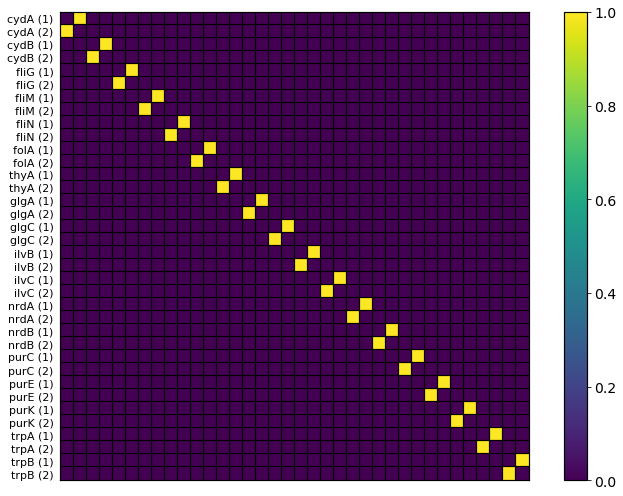

In [93]:
#plotting the results
DIVIDERWIDTH = 1.2
plt.figure(figsize=(10,7))
plt.rcParams['axes.linewidth'] = DIVIDERWIDTH # Change axes thickness

#Stuff for generative divider lines
Nprot = len(ps.prots)
span = np.array([0,Nprot]) - 0.5
ticks = np.convolve(np.insert(range(1,Nprot+1), 0, 0), np.ones((2,))/2, mode='valid') - 0.5 
divs = ticks+0.5
ones = np.ones(2)
opts = {'left':'off','bottom':'off', 'top':'off', 'labelbottom':'off','labeltop':'off'}

plt.imshow(sameProt,cmap='viridis');
opts = {'left':'off','bottom':'off', 'top':'off', 'labelbottom':'off','labeltop':'off'}
plt.tick_params(axis='both', **opts)

label_names = [ name.split('_')[0]+' ('+name.split('_')[1][-1]+')' for name in ps.names ]
plt.yticks(ticks, label_names, size=11);
    
# This code is adapted from my thesis and adds black divider lines
for pos in divs[:-1]:
    plt.plot(span, (pos-0.1)*ones, color='k', linewidth=DIVIDERWIDTH)
    plt.plot((pos-0.05)*ones, span, color='k', linewidth=DIVIDERWIDTH)
    
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=14);
plt.tight_layout()

In [100]:
#this is plotting code - for making the box and whiskers plots below.
def fancy_box(data,names,outliers=False, fsize=(8,6)):
    plt.figure(figsize=fsize)
    ax = plt.gca()
    bp = ax.boxplot(data, patch_artist=True, showfliers=outliers)
    lw = 2.5
    for box in bp['boxes']:
        box.set(color='#7570b3', linewidth=lw)
        box.set(facecolor='#1b9e77' )
    for whisker in bp['whiskers']:
        whisker.set(color='#7570b3', linewidth=lw)
    for cap in bp['caps']:
        cap.set(color='#7570b3', linewidth=lw)
    for median in bp['medians']:
        median.set(color='#b2df8a', linewidth=lw)

In [101]:
temp = map(lambda mat: mt_mat2[np.triu(mat.astype(bool))].flatten(),[sameProt,physInt,enzInt,negatives])

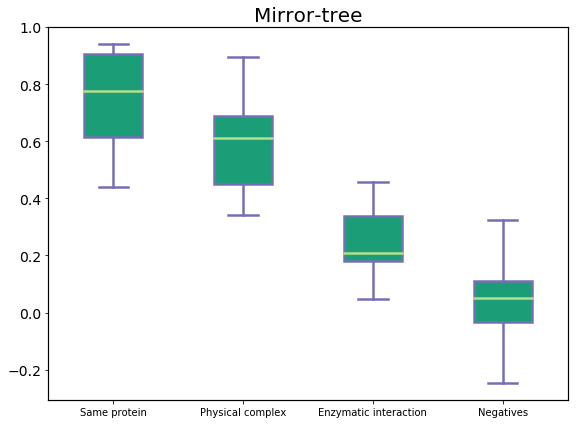

In [118]:
fancy_box(temp,names,outliers=False) # I need a better looking outlier marker
plt.title('Mirror-tree',fontsize=20);
plt.tight_layout()
plt.xticks(range(1,5),['Same protein','Physical complex', 'Enzymatic interaction', 'Negatives'],fontsize=10);
plt.yticks(fontsize=14);

In [122]:
temp2 = map(lambda mat: sca_intrxn[np.triu(mat.astype(bool))].flatten(),[sameProt,physInt,enzInt,negatives])

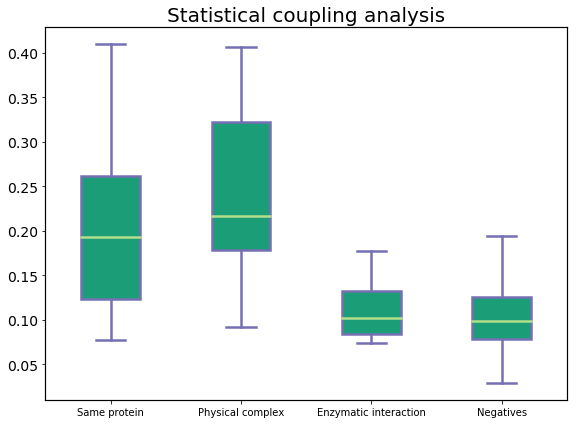

In [123]:
fancy_box(temp2,names,outliers=False) # I need a better looking outlier marker
plt.title('Statistical coupling analysis',fontsize=20);
plt.tight_layout()
plt.xticks(range(1,5),['Same protein','Physical complex', 'Enzymatic interaction', 'Negatives'],fontsize=10);
plt.yticks(fontsize=14);